In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from skimage.io import imread
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
class MyDataset(Dataset):
    def __init__(self, filename, image_dir, repeat=1):
        '''
        :param filename: TXT file：content: imge_name.jpg label1_id labe2_id...
        :param image_dir: the dir of images
        :param repeat: the times of data being used, default 1
        '''
        self.image_label_list = self.read_file(filename)
        self.image_dir = image_dir
        self.len = len(self.image_label_list)
        self.repeat = repeat
        self.transform=transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))])
 
    def __getitem__(self, i):
        """
        get the images and labels
        """
        index = i % self.len
        image_name, label = self.image_label_list[index]
        label = torch.tensor(label)
        image_path = os.path.join(self.image_dir, image_name)
        img = self.data_process(image_path, normalization=True)
        return img, label
 
    def __len__(self):
        """
        get the length of data
        """
        if self.repeat == None:
            data_len = 10000000
        else:
            data_len = len(self.image_label_list) * self.repeat
        return data_len
 
    def read_file(self, filename):
        """
        read the txt file and get the labels of images
        """
        image_label_list = []
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                content = line.rstrip().split(' ')
                name = content[0]
                labels = []
                for value in content[1:]:
                    labels.append(int(value))
                image_label_list.append((name, labels))
        return image_label_list
 
    def data_process(self, path, normalization):
        '''
        load and preprocess the images
        '''
        img = imread(path)
        if normalization is True:
            img = self.transform(img)
        img = np.asarray(img,dtype='float64')
        return img

In [3]:
train_filename="./dataset/train.txt"
test_filename="./dataset/test.txt"
train_image_dir='./dataset/train'
test_image_dir='./dataset/test'

batch_size=4
train_data_nums=10

train_data = MyDataset(filename=train_filename, image_dir=train_image_dir,repeat=1)
test_data = MyDataset(filename=test_filename, image_dir=test_image_dir,repeat=1)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size,shuffle=True)

#check the size of data
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_targets = example_targets.t()
example_targets = example_targets.squeeze()
print(example_targets.shape)
print(example_data.shape)

torch.Size([4])
torch.Size([4, 1, 28, 28])


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)#kernal size is 5 * 5
        self.pool1 = nn.MaxPool2d(2, 2)#pooling window is 2 * 2
        self.conv2 = nn.Conv2d(10, 20, 5)#kernal size is 5 * 5
        self.pool2 = nn.MaxPool2d(2, 2)#pooling window is 2 * 2
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, input):
        x = self.pool1(F.relu(self.conv1(input)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 320)#reshape x into u * 320, u is unknown
        x = self.fc2(self.fc1(x))
        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

Train Epoch: 1 [0/10000 (0%)]	Loss:2.346484


D:\Python\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [40/10000 (0%)]	Loss:2.267194
Train Epoch: 1 [80/10000 (1%)]	Loss:2.288155
Train Epoch: 1 [120/10000 (1%)]	Loss:2.282577
Train Epoch: 1 [160/10000 (2%)]	Loss:2.069566
Train Epoch: 1 [200/10000 (2%)]	Loss:2.412977
Train Epoch: 1 [240/10000 (2%)]	Loss:1.766420
Train Epoch: 1 [280/10000 (3%)]	Loss:1.912040
Train Epoch: 1 [320/10000 (3%)]	Loss:1.546188
Train Epoch: 1 [360/10000 (4%)]	Loss:1.487997
Train Epoch: 1 [400/10000 (4%)]	Loss:1.187704
Train Epoch: 1 [440/10000 (4%)]	Loss:0.972226
Train Epoch: 1 [480/10000 (5%)]	Loss:0.760886
Train Epoch: 1 [520/10000 (5%)]	Loss:0.297565
Train Epoch: 1 [560/10000 (6%)]	Loss:1.898386
Train Epoch: 1 [600/10000 (6%)]	Loss:0.512776
Train Epoch: 1 [640/10000 (6%)]	Loss:0.638167
Train Epoch: 1 [680/10000 (7%)]	Loss:0.243518
Train Epoch: 1 [720/10000 (7%)]	Loss:0.563941
Train Epoch: 1 [760/10000 (8%)]	Loss:0.951899
Train Epoch: 1 [800/10000 (8%)]	Loss:1.095852
Train Epoch: 1 [840/10000 (8%)]	Loss:0.610046
Train Epoch: 1 [880/10000 (9%)]	Loss

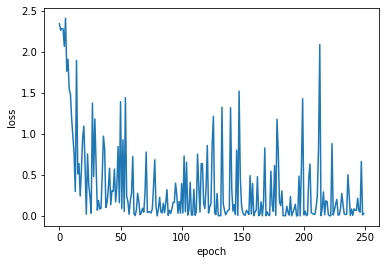

In [5]:
train_losses = []
train_counter = []

def train(epoch):
  net.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    #process the data to adjust to the net
    if data.shape == torch.Size([4,28,1,28]):
      data = data.permute(0,2,1,3)
    data = data.float()
    target = target.t()
    target = target.squeeze()
    #train the model
    output = net(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({(100. * batch_idx / len(train_loader)):.0f}%)]\tLoss:{loss.item():.6f}")
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*100) + ((epoch-1)*len(train_loader.dataset)))
      #save the parameters of model in params.pkl
      torch.save(net.state_dict(), 'params.pkl')
  # get the loss figure
  plt.plot(train_losses)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
          
train(1)

In [6]:
test_losses = []

def test():
  #load the parameters of model from params.pkl
  net.load_state_dict(torch.load('params.pkl'))
  net.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      #process the data to adjust to the net
      if data.shape == torch.Size([4,28,1,28]):
        data = data.permute(0,2,1,3)
      data = data.float()
      target = target.t()
      target = target.squeeze()
      #test and evaluate the model
      output = net(data)
      test_loss += criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      print(pred)
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print(f'\nTest set: Avg loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}({(100.* correct / len(test_loader.dataset)):.0f}%)\n')
    
test()

tensor([[4],
        [9],
        [9],
        [4]])
tensor([[3],
        [0],
        [0],
        [1]])
tensor([[6],
        [0],
        [0],
        [2]])
tensor([[2],
        [1],
        [0],
        [8]])
tensor([[8],
        [4],
        [6],
        [4]])
tensor([[5],
        [9],
        [3],
        [5]])
tensor([[8],
        [7],
        [5],
        [7]])
tensor([[0],
        [0],
        [4],
        [5]])
tensor([[6],
        [5],
        [6],
        [8]])
tensor([[3],
        [0],
        [2],
        [7]])
tensor([[0],
        [9],
        [3],
        [3]])
tensor([[1],
        [2],
        [1],
        [8]])
tensor([[6],
        [0],
        [7],
        [4]])
tensor([[4],
        [9],
        [8],
        [5]])
tensor([[9],
        [2],
        [8],
        [5]])
tensor([[9],
        [9],
        [3],
        [4]])
tensor([[6],
        [1],
        [0],
        [7]])
tensor([[9],
        [9],
        [7],
        [3]])
tensor([[0],
        [0],
        [2],
       